# Stock Price Prediction using Echo State Networks

## Introduction

Time Series Prediction is one important regression task, which can be solved using several Machine Learning techniques.

In this notebook, we would like to briefly introduce one very bais example for Time Series prediction:

Stock Price Prediction

Please note that this notebook is not supposed to be used for serious stock price analysis, and we will not give any
warranty that the approach will work in practice.

At first, we need to import all required packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from pyrcn.echo_state_network import ESNRegressor

## Loading and visualizing stock prices

A good ressource for stock prices is Yahoo Finance ([https://finance.yahoo.com/](https://finance.yahoo.com/)), where a
lot of financial data can be downloaded as csv files.

We have already downloaded several stock prices, which are all stored in the directory "dataset".

Now, we are working with the gold price in USD (Gold Aug 20(GC=F)) between 2000-02-28 and 2020-05-28.

In [2]:
time_series = pd.read_csv(filepath_or_buffer="./dataset/GC=F.csv")
time_series.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-28,292.299988,292.500000,292.299988,292.500000,292.500000,4.0
1,2000-02-29,292.399994,292.399994,292.399994,292.399994,292.399994,7.0
2,2000-03-01,291.500000,291.500000,291.500000,291.500000,291.500000,0.0
3,2000-03-02,288.200012,291.500000,288.000000,288.200012,288.200012,100.0
4,2000-03-03,288.799988,288.799988,288.799988,288.799988,288.799988,10.0


Analyzing the dataset, we can analyze the structure. The first column is the date, the second column is the open value,
e.g. the first value of a day.
The third column is the highest value of a specific day, the fourth column the lowest and "Close" is the final value of
a day. The "Adj Close" is a corrected  final value, I DON 'T YET KNOW ANYTHING ABOUT VOLUME!!!

Here, we just use the "Close" value, the final value of one day. 

In [3]:
time_series = time_series.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], axis=1)
time_series = time_series.dropna()
time_series.head()

,Date,Close
0,2000-02-28,292.500000
1,2000-02-29,292.399994
2,2000-03-01,291.500000
3,2000-03-02,288.200012
4,2000-03-03,288.799988


As one can see, the stock price trends upwards for the first few thousand days. Then goes down at around $n=\num{3300}$ before climbing again after around $n = 4900$. 

Text(0, 0.5, 'Price')

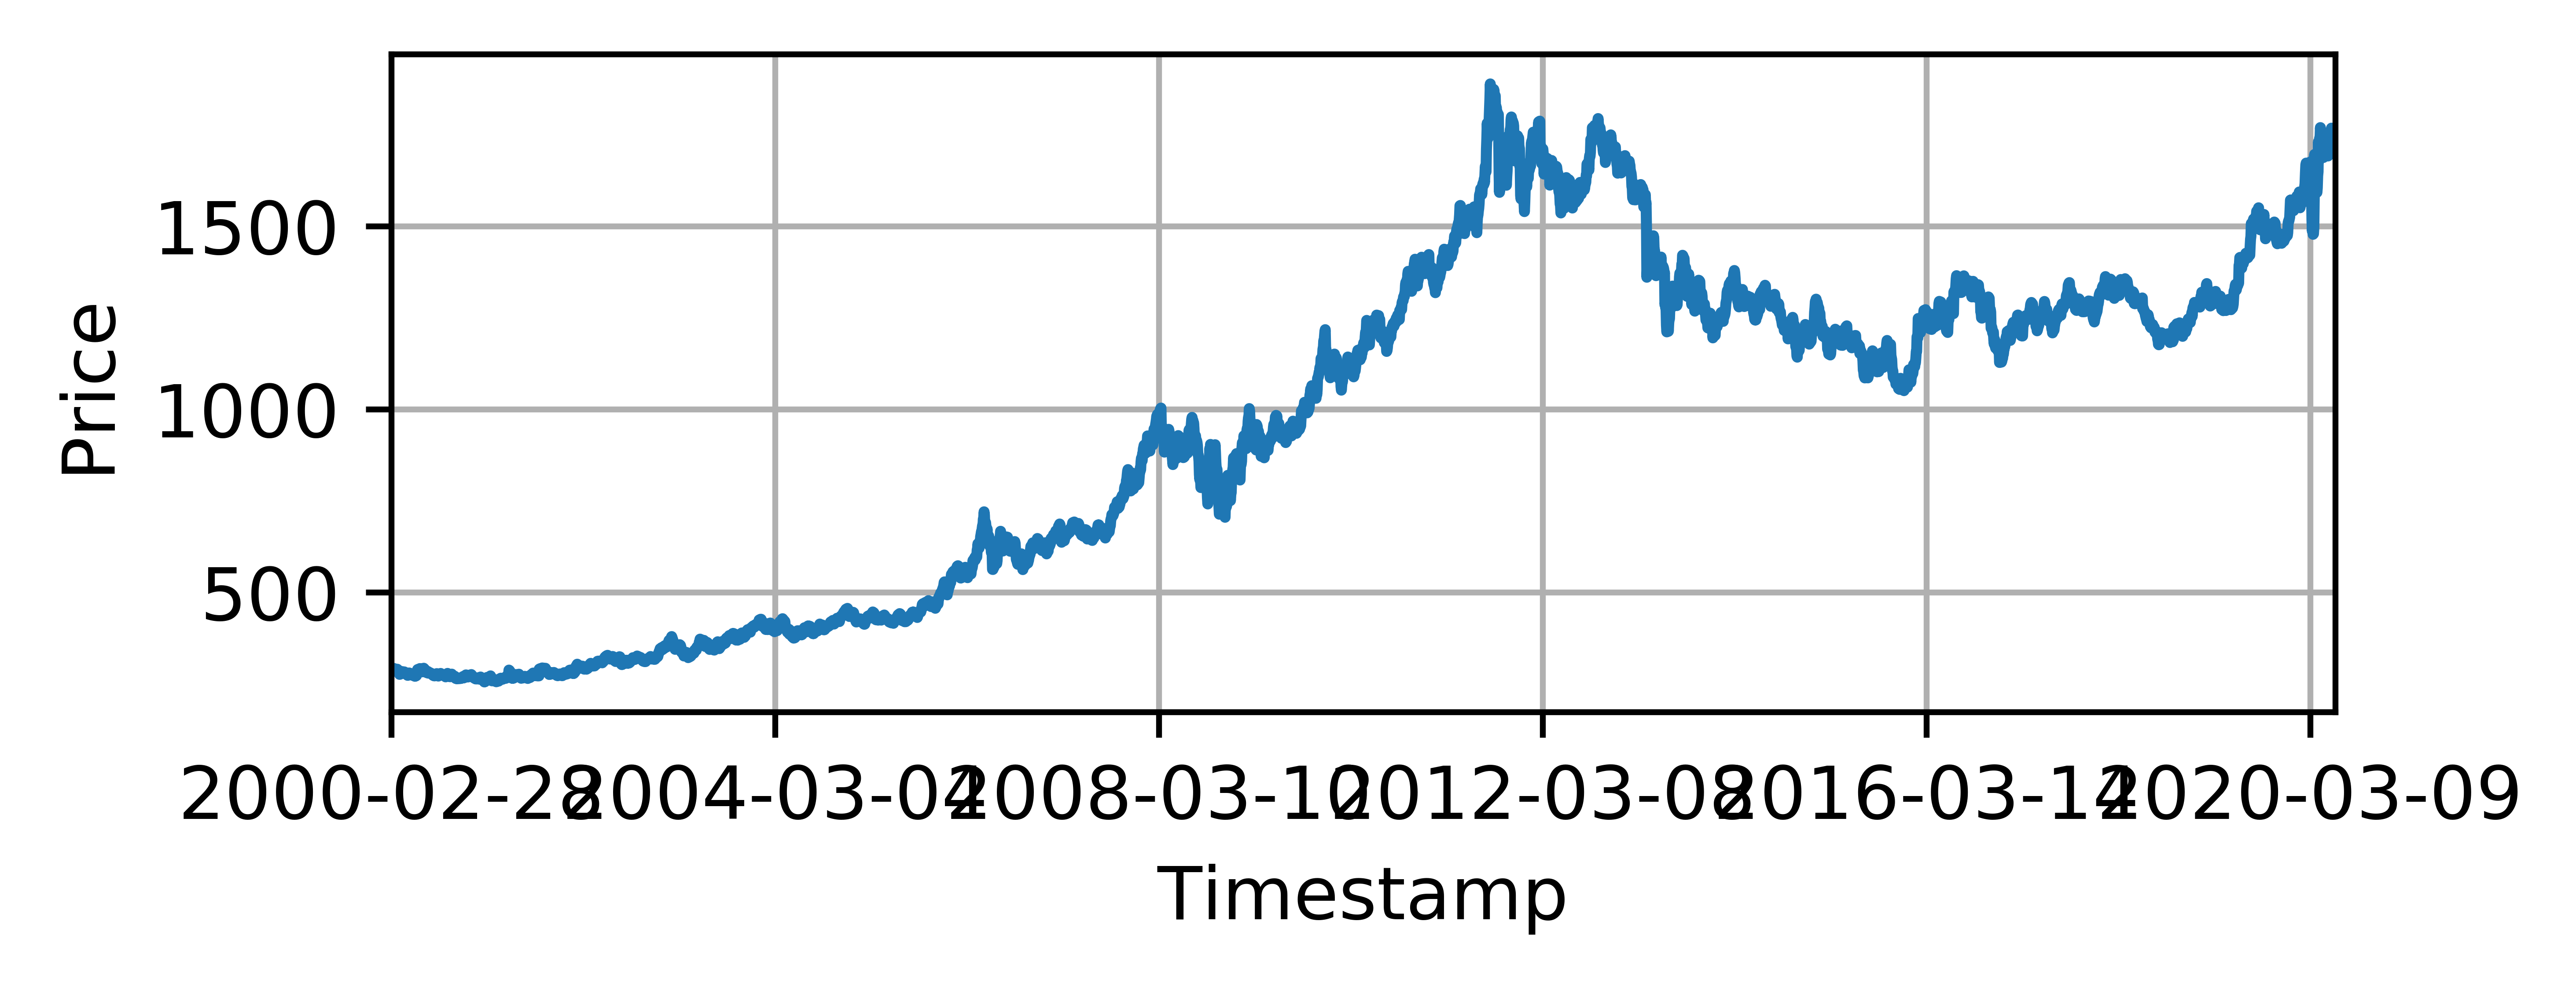

In [4]:
_, ax = plt.subplots(figsize=(4.75, 1.65), dpi=1200)
time_series.plot(x='Date', y='Close', ax=ax, legend=False, grid=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Price")

We pre-processed the dataset by removing undefined values, namely, weekends and public holidays. The remaining values were normalized to be in a range of $[0 1]$.

In [5]:
prices = np.asarray(time_series['Close'])

scaler = MinMaxScaler()
prices = scaler.fit_transform(X=prices.reshape(-1, 1))

Define Train/Test lengths:

The first 3000 values were used to train the ESN and to optimize the hyper-parameters and the rest for testing. 

In [6]:
train_len = 3000
future_len = 1
future_total = len(prices) - train_len

Echo State Network preparation

In [7]:
esn = ESNRegressor(k_in=1, input_scaling=0.6, spectral_radius=0.9, bias=0.0, ext_bias=False, leakage=1.0,
                   reservoir_size=100, k_res=10, reservoir_activation='tanh', bi_directional=False,
                   teacher_scaling=1., teacher_shift=0., solver='ridge', beta=1e-8, random_state=0)

Training and Prediction.

In [8]:
train_in = prices[0:train_len, :]
train_out = prices[0+1:train_len+1, :]
test_in = prices[0:train_len+future_total - future_len, :]
test_out = prices[future_len:train_len+future_total, :]

esn.fit(X=train_in, y=train_out.ravel())
train_pred = esn.predict(X=train_in)
test_pred = esn.predict(X=test_in)

train_err = mean_squared_error(y_true=train_out, y_pred=train_pred)
test_err = mean_squared_error(y_true=test_out[train_len+1:, :], y_pred=test_pred[train_len+1:])

print("Train MSE:\t{0}".format(train_err))
print("Test MSE:\t{0}".format(test_err))

Train MSE:	3.7788642391830205e-05
Test MSE:	8.067299296986916e-05


We see that the ESN even captures the downward trend in the test set, although it has not seen any longer downward movement during the training.

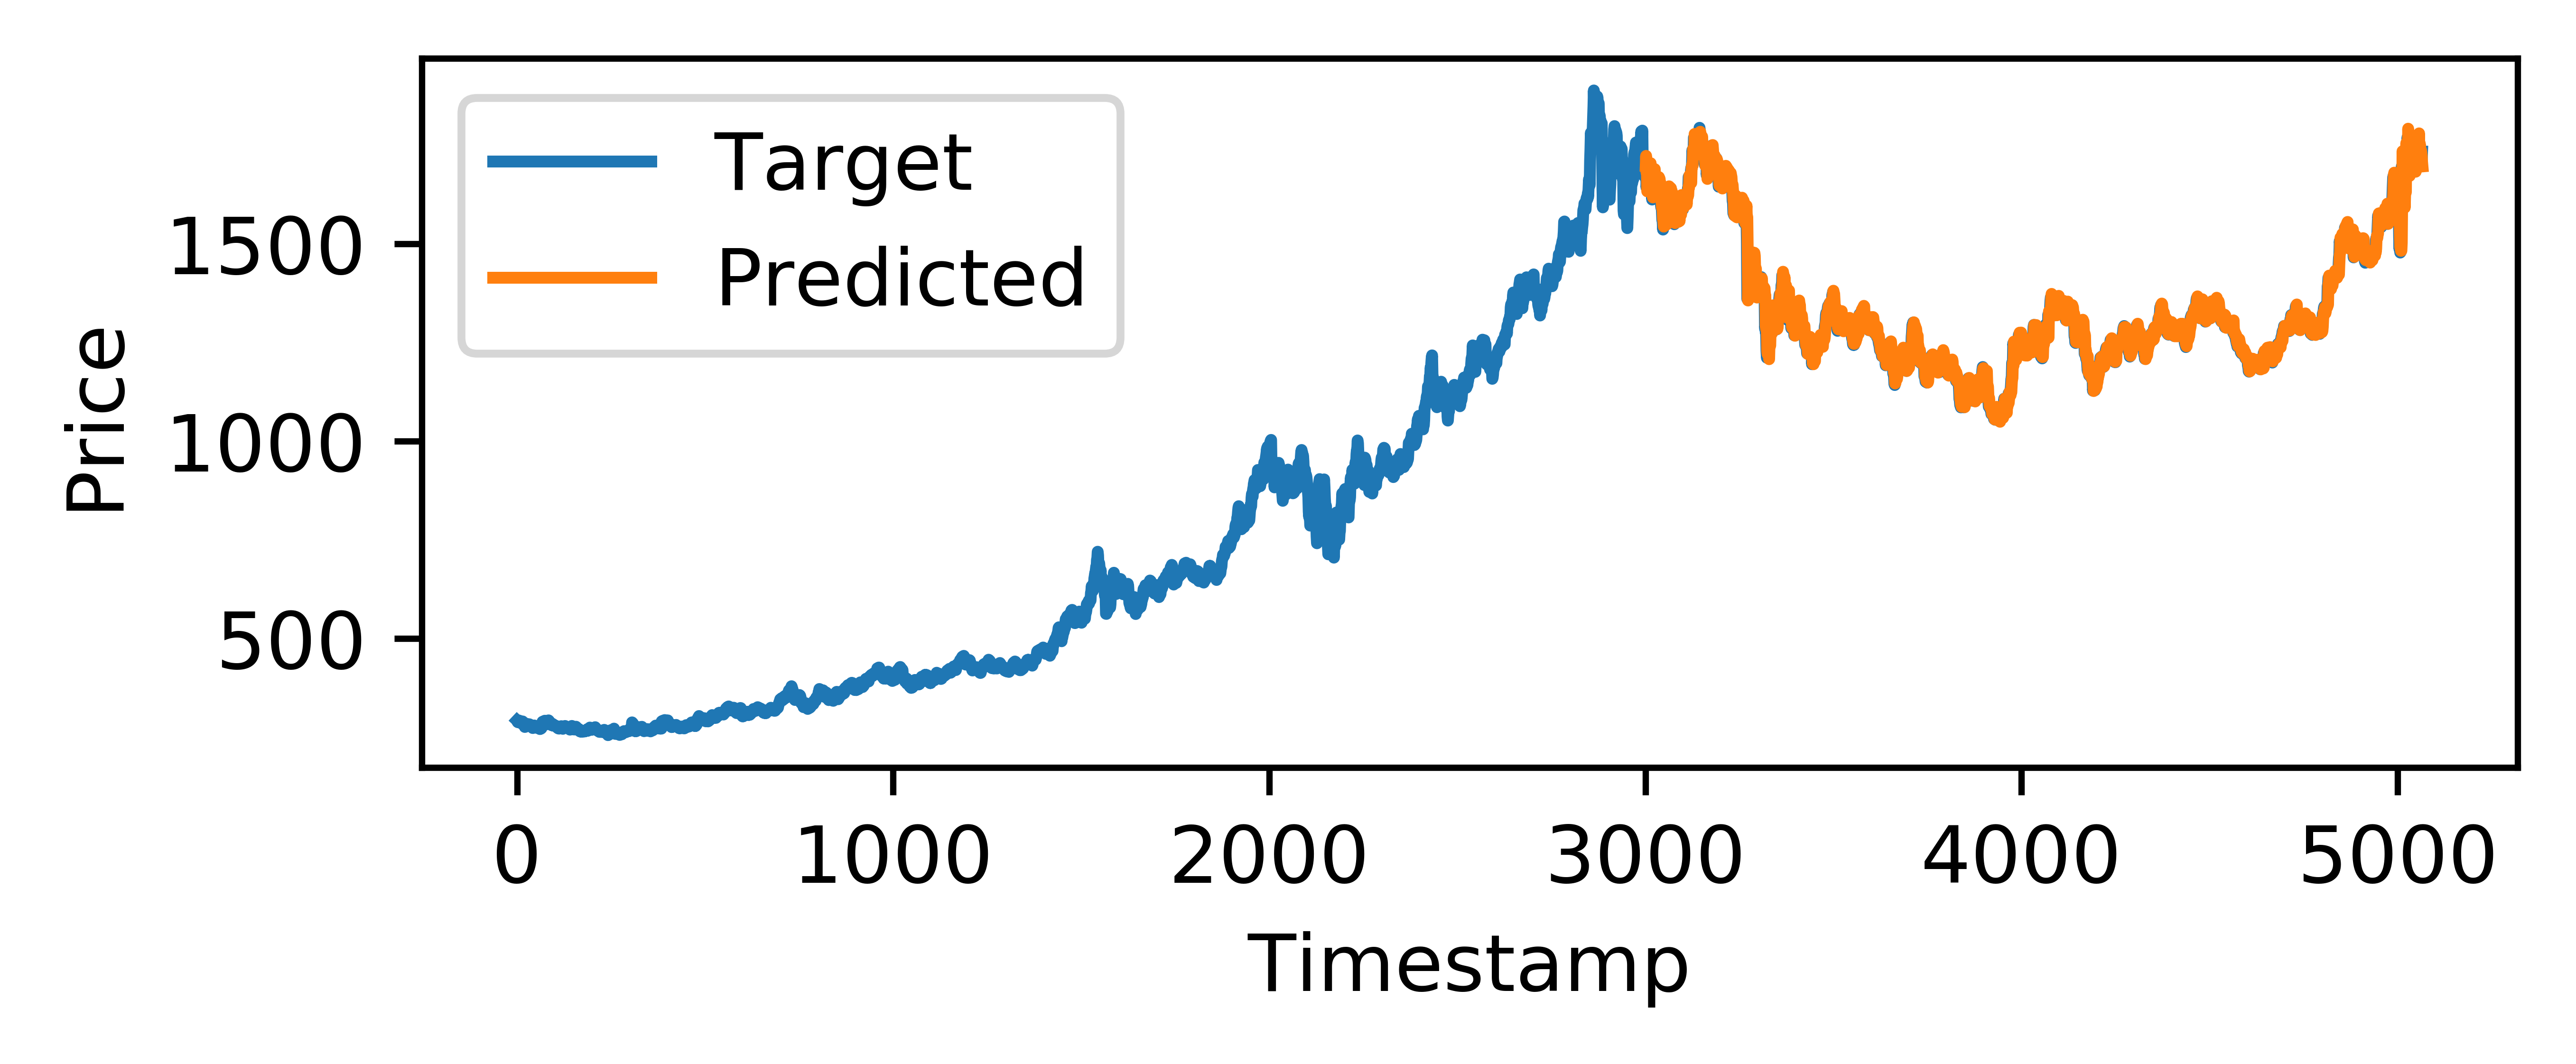

In [9]:
prices_pred = np.empty_like(prices)
prices_pred[:] = np.nan
prices_pred[train_len + future_len:, 0] = test_pred[train_len:]

_, ax = plt.subplots(figsize=(4.75, 1.65), dpi=1200)
ax.plot(scaler.inverse_transform(test_out), label='Target')
ax.plot(scaler.inverse_transform(prices_pred), label='Predicted')
ax.set_xlabel("Timestamp")
ax.set_ylabel("Price")
ax.legend()

We are experts in signal processing. Please notice that we do not give any kind of financial advice here! In the financial world, we are sure that much more effective models for time series prediction exist, which include actual background information.